In [16]:
import os
import glob
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from gym_env import StockTradingEnv
from ppo_agent import PPOAgent
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scaler = MinMaxScaler()

In [17]:
def compute_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()


def compute_macd(df, price_col='adj_close', span_short=12, span_long=26):
    ema_short = compute_ema(df[price_col], span=span_short)
    ema_long = compute_ema(df[price_col], span=span_long)
    macd = ema_short - ema_long
    return macd


def compute_rsi(df, price_col='adj_close', window=14):
    delta = df[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1 / window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / window, adjust=False).mean()
    rs = avg_gain / (avg_loss + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return rsi


def compute_cci(df, window=20):
    tp = (df['high'] + df['low'] + df['close']) / 3
    sma = tp.rolling(window=window).mean()
    mad = tp.rolling(window=window).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci = (tp - sma) / (0.015 * mad + 1e-8)
    return cci


def compute_adx(df, window=14):
    high = df['high']
    low = df['low']
    close = df['close']
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    up_move = high - high.shift()
    down_move = low.shift() - low
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
    plus_dm = pd.Series(plus_dm, index=df.index)
    minus_dm = pd.Series(minus_dm, index=df.index)
    plus_di = 100 * (plus_dm.rolling(window=window).sum() / (atr + 1e-8))
    minus_di = 100 * (minus_dm.rolling(window=window).sum() / (atr + 1e-8))
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di + 1e-8))
    adx = dx.rolling(window=window).mean()
    return adx

In [18]:
def load_data(data_folder, n_stocks=30, sentiment=True):
    """
    Loads CSV files from the given folder, computes technical indicators (price, MACD, RSI, CCI, ADX)
    for each stock, aligns them by common dates, and returns a dictionary of NumPy arrays:
      - Each array has shape (num_timesteps, n_stocks)
    """
    check_stock_dates(data_folder)
    indicators = get_indicators(data_folder, sentiment=sentiment)
    common_index = determine_index_range(indicators)
    print(f"Common date range: {common_index[0]} to {common_index[-1]}")
    combined = {}
    for ind in indicators:
        df_list = []
        for key in sorted(indicators[ind].keys())[:n_stocks]:
            s = indicators[ind][key].reindex(common_index).ffill().bfill()
            df_list.append(s)
        combined[ind] = pd.concat(df_list, axis=1)
        combined[ind].columns = sorted(indicators[ind].keys())[:n_stocks]
    if len(common_index) == 0:
        raise ValueError("No common dates found among CSV files.")
    data_arrays = {ind: combined[ind].values for ind in combined}
    return data_arrays

In [19]:
def check_stock_dates(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    if not csv_files:
        print("No CSV files found in the folder.")
        return
    for csv_file in csv_files:
        file_name = os.path.basename(csv_file)
        try:
            df = pd.read_csv(csv_file, parse_dates=['date'])
            if 'date' not in df.columns:
                raise ValueError(f"{file_name} does not contain a 'date' column.")
            if df.empty:
                raise ValueError(f"{file_name} is empty.")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

In [20]:
def get_indicators(data_folder, sentiment):
    file_paths = sorted(glob.glob(os.path.join(data_folder, "*.csv")))
    if not file_paths:
        raise ValueError(f"No CSV files found in folder {data_folder}")
    if sentiment:
        indicators = {
            'price': {},
            'MACD': {},
            'RSI': {},
            'CCI': {},
            'ADX': {},
            'scaled_sentiment': {},
        }
    else:
        indicators = {
            'price': {},
            'MACD': {},
            'RSI': {},
            'CCI': {},
            'ADX': {},
        }
    for fp in file_paths:
        df = pd.read_csv(fp, parse_dates=['date'])
        df['date'] = pd.to_datetime(df['date']).dt.date
        df.sort_values('date', inplace=True)
        df.set_index('date', inplace=True)
        df['adj_close'] = scaler.fit_transform(df['adj_close'].values.reshape(-1, 1)).flatten()
        price = df['adj_close']
        macd = compute_macd(df, price_col='adj_close')
        rsi = compute_rsi(df, price_col='adj_close')
        cci = compute_cci(df, window=20)
        adx = compute_adx(df, window=14)
        stock_key = os.path.splitext(os.path.basename(fp))[0]
        if sentiment:
            scaled_sentiment = np.mean(df['scaled_sentiment'].values)
            scaled_sentiment = pd.Series([scaled_sentiment] * len(price), index=price.index)
            indicators['scaled_sentiment'][stock_key] = scaled_sentiment
        indicators['price'][stock_key] = price
        indicators['MACD'][stock_key] = macd
        indicators['RSI'][stock_key] = rsi
        indicators['CCI'][stock_key] = cci
        indicators['ADX'][stock_key] = adx
    return indicators

In [21]:
def determine_index_range(indicators):
    price_data = indicators['price']
    stock_dates = {stock: (df.index.min(), df.index.max()) for stock, df in price_data.items()}
    highest_start_stock, (highest_start, _) = max(stock_dates.items(), key=lambda item: item[1][0])
    lowest_end_stock, (_, lowest_end) = min(stock_dates.items(), key=lambda item: item[1][1])
    common_start = max(start for start, _ in stock_dates.values())
    common_end = min(end for _, end in stock_dates.values())
    while common_start > common_end:
        price_data.pop(highest_start_stock, None)
        price_data.pop(lowest_end_stock, None)
        if not price_data:
            raise ValueError("No stocks remaining after exclusion. Check date ranges.")
        stock_dates = {stock: (df.index.min(), df.index.max()) for stock, df in price_data.items()}
        common_start = max(start for start, _ in stock_dates.values())
        common_end = min(end for _, end in stock_dates.values())
    print(f"Remaining stocks: {len(price_data)}")
    print(f"Common start date: {common_start}")
    print(f"Common end date: {common_end}")
    return pd.date_range(start=common_start, end=common_end, freq='D')

In [22]:
def backtest_agent(agent, env, time_window):
    # Retrieve historical prices from the dataset before forecasting starts
    historical_prices = env.data['price'][:env.current_step]  # FIX: Correct historical price retrieval

    state = env.reset()
    state_seq = np.array([state] * time_window)
    portfolio_values = []
    true_prices = []  # Store true stock prices
    predicted_prices = []  # Store predicted stock prices
    done = False

    # Track portfolio from start
    initial_portfolio = env.balance + np.sum(env.prices * env.stock_owned)
    portfolio_values.append(initial_portfolio)

    while not done:
        action, _, _ = agent.select_action(state_seq)
        next_state, _, done, _ = env.step(action)

        current_portfolio = env.balance + np.sum(env.prices * env.stock_owned)
        portfolio_values.append(current_portfolio)

        # Store true prices AFTER executing the action
        true_prices.append(env.prices.copy())

        # FIX: Scale predicted prices properly
        predicted_prices.append(env.prices * (1 + 0.05 * action))  # Smaller action scaling

        # Update state sequence
        state_seq = np.vstack([state_seq[1:], next_state])

    return (
        portfolio_values,
        np.array(historical_prices),  # FIX: Return correct historical prices
        np.array(true_prices),
        np.array(predicted_prices),
    )

In [23]:
def compute_performance_metrics(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    cumulative_return = (final_value - initial_value) / initial_value
    max_earning_rate = np.max((portfolio_values - initial_value) / initial_value)
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    sharpe_ratio = (np.mean(daily_returns) / (np.std(daily_returns) + 1e-8)) * np.sqrt(252)
    return cumulative_return, max_earning_rate, sharpe_ratio

In [24]:
# Suppress TensorFlow and Python warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [25]:
# Current date for directory naming
curr_date = datetime.now().strftime("%Y%m%d%H%M")

In [26]:
# Hyperparameters (Optimized for Higher Cumulative Return)
TIME_WINDOW = 60  # Increased to capture longer trends
SENTIMENT = "sentiment"  # "sentiment" or "no_sentiment"
STATE_DIM = 1 + 30 * 7 if SENTIMENT == "sentiment" else 1 + 30 * 6
FEATURE_DIM = 256  # Increased to allow better feature representation
N_STOCKS = 30
TOTAL_TIMESTEPS = 100000  # Increased training duration for better convergence
UPDATE_TIMESTEP = 64  # More frequent updates to stabilize learning
LR = 5e-4  # Increased slightly for faster learning
DATA_FOLDER = "datasets/data_50"
INITIAL_BALANCE = 1e6
MAX_SHARES = 2000  # Increased to allow larger positions
REWARD_SCALING = 5e-3  # Adjusted for better reward signal balance
TURBULENCE_THRESHOLD = 150  # Increased to allow more trading in volatile markets

# Verify data folder exists
if not os.path.exists(DATA_FOLDER):
    raise FileNotFoundError(f"Data folder {DATA_FOLDER} does not exist.")

In [83]:
# Create directories for results
results_dir = f'results/{SENTIMENT}_{N_STOCKS}_{curr_date}'
plots_path = os.path.join(results_dir, 'plots')
saved_models_path = os.path.join(results_dir, 'saved_models')
evaluations_path = os.path.join(results_dir, 'evaluations')
os.makedirs(plots_path, exist_ok=True)
os.makedirs(saved_models_path, exist_ok=True)
os.makedirs(evaluations_path, exist_ok=True)

In [28]:
# Save configuration
config_path = os.path.join(results_dir, 'config.txt')
with open(config_path, 'w') as f:
    f.write(f'Time window: {TIME_WINDOW}\n'
            f'Sentiment: {SENTIMENT}\n'
            f'State dimension: {STATE_DIM}\n'
            f'Feature dimension: {FEATURE_DIM}\n'
            f'Number of stocks: {N_STOCKS}\n'
            f'Total timesteps: {TOTAL_TIMESTEPS}\n'
            f'Update timestep: {UPDATE_TIMESTEP}\n'
            f'Learning rate: {LR}\n'
            f'Initial balance: {INITIAL_BALANCE}\n'
            f'Max shares: {MAX_SHARES}\n'
            f'Reward scaling: {REWARD_SCALING}\n'
            f'Turbulence threshold: {TURBULENCE_THRESHOLD}\n')

# Display configuration
print(f'----- Training with {N_STOCKS} stocks and sentiment: {SENTIMENT} -----')
with open(config_path, 'r') as f:
    print(f.read())

----- Training with 48 stocks and sentiment: sentiment -----
Time window: 60
Sentiment: sentiment
State dimension: 337
Feature dimension: 256
Number of stocks: 48
Total timesteps: 100000
Update timestep: 64
Learning rate: 0.0005
Initial balance: 1000000.0
Max shares: 2000
Reward scaling: 0.005
Turbulence threshold: 150



In [74]:
# Load data and create environments
data = load_data(data_folder=DATA_FOLDER, n_stocks=N_STOCKS, sentiment=(SENTIMENT == "sentiment"))
total_steps = data['price'].shape[0]
split_index = int(total_steps * 0.8)  # 80% training, 20% testing

train_data = {k: v[:split_index] for k, v in data.items()}
test_data = {k: v[split_index:] for k, v in data.items()}

train_env = StockTradingEnv(
    data=train_data,
    initial_balance=INITIAL_BALANCE,
    max_shares=MAX_SHARES,
    reward_scaling=REWARD_SCALING,
    turbulence_threshold=TURBULENCE_THRESHOLD,
    state_dim=STATE_DIM,
    n_stocks=N_STOCKS,
    sentiment=(SENTIMENT == "sentiment"),
    scaler=scaler
)
test_env = StockTradingEnv(
    data=test_data,
    initial_balance=INITIAL_BALANCE,
    max_shares=MAX_SHARES,
    reward_scaling=REWARD_SCALING,
    turbulence_threshold=TURBULENCE_THRESHOLD,
    state_dim=STATE_DIM,
    n_stocks=N_STOCKS,
    sentiment=(SENTIMENT == "sentiment"),
    scaler=scaler
)

# Define model file paths
lstm_pre_path = Path(saved_models_path) / 'lstm_pre.keras'
actor_path = Path(saved_models_path) / 'lstm_actor.keras'
critic_path = Path(saved_models_path) / 'lstm_critic.keras'

# Initialize agent
agent = PPOAgent(
    time_window=TIME_WINDOW,
    state_dim=STATE_DIM,
    feature_dim=FEATURE_DIM,
    n_stocks=N_STOCKS,
    lr=LR
)

Remaining stocks: 48
Common start date: 2022-11-22
Common end date: 2023-12-15
Common date range: 2022-11-22 00:00:00 to 2023-12-15 00:00:00


In [30]:

# Check if model files exist
if lstm_pre_path.exists() and actor_path.exists() and critic_path.exists():
    # Load existing models
    print('----- Loading existing models for evaluation -----')
    agent.lstm_pre = tf.keras.models.load_model(lstm_pre_path)
    agent.actor = tf.keras.models.load_model(actor_path)
    agent.critic = tf.keras.models.load_model(critic_path)
else:
    # Train models
    train_start_time = datetime.now()
    print(f'----- Started training at: {train_start_time.strftime("%Y-%m-%d %H:%M:%S")} -----')
    agent.train(train_env, total_timesteps=TOTAL_TIMESTEPS, update_timestep=UPDATE_TIMESTEP)
    train_end_time = datetime.now()
    duration = (train_end_time - train_start_time).total_seconds() / 60
    print(
        f'----- Finished training at: {train_end_time.strftime("%Y-%m-%d %H:%M:%S")}, duration: {duration:.2f} minutes -----')

    # Save models
    agent.lstm_pre.save(lstm_pre_path)
    agent.actor.save(actor_path)
    agent.critic.save(critic_path)

----- Started training at: 2025-03-10 19:52:12 -----


2025-03-10 19:52:12.575449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-10 19:52:15.835356: I external/local_xla/xla/service/service.cc:168] XLA service 0x55e499d65390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-10 19:52:15.835398: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-10 19:52:15.849910: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741632735.956882   46840 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


----- Finished training at: 2025-03-10 20:40:21, duration: 48.15 minutes -----


----- Evaluating agent -----
Cumulative Return: 8.94%
Maximum Earning Rate: 9.10%
Sharpe Ratio: 3.17


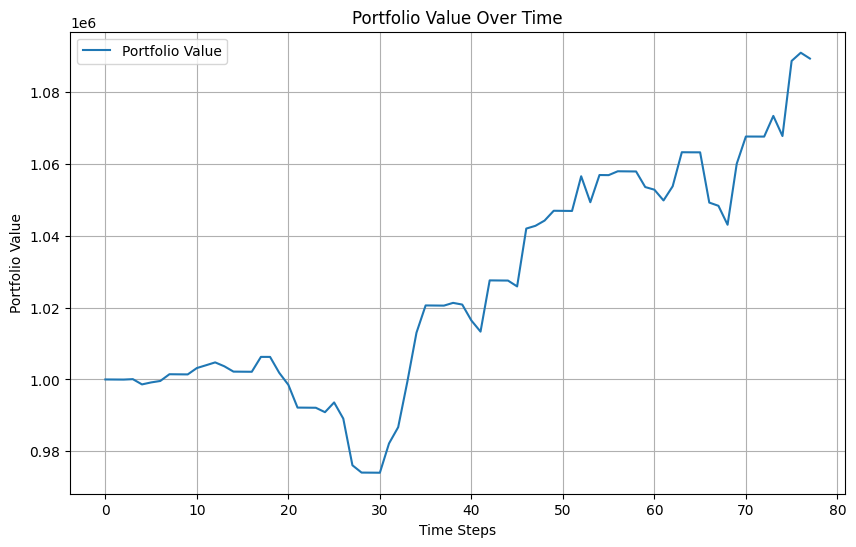

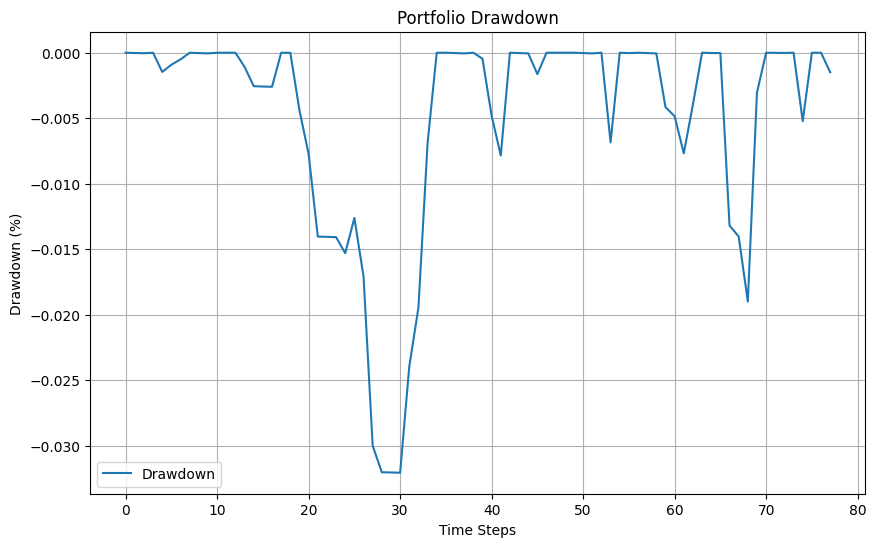

In [36]:
# Evaluate the agent
print('----- Evaluating agent -----')
portfolio_values, historical_prices, true_prices, predicted_prices = backtest_agent(agent, test_env, TIME_WINDOW)
# Save evaluation results also with the stock names
np.save(os.path.join(evaluations_path, 'true_prices.npy'), true_prices)
np.save(os.path.join(evaluations_path, 'predicted_prices.npy'), predicted_prices)
cr, mer, sr = compute_performance_metrics(portfolio_values)

print(f"Cumulative Return: {cr * 100:.2f}%")
print(f"Maximum Earning Rate: {mer * 100:.2f}%")
print(f"Sharpe Ratio: {sr:.2f}")

# Save portfolio values to CSV
portfolio_values_path = os.path.join(evaluations_path, 'portfolio_values.csv')
pd.Series(portfolio_values).to_csv(portfolio_values_path)

# Save performance metrics to a text file
performance_metrics_path = os.path.join(evaluations_path, f'performance_metrics_{SENTIMENT}.txt')
with open(performance_metrics_path, "w") as f:
    f.write(f"Cumulative Return: {cr * 100:.2f}%\n")
    f.write(f"Maximum Earning Rate: {mer * 100:.2f}%\n")
    f.write(f"Sharpe Ratio: {sr:.2f}\n")

# Plot and save portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label="Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_path, 'portfolio_value.png'))
plt.show()

# Compute drawdowns
portfolio_series = pd.Series(portfolio_values)
rolling_max = portfolio_series.cummax()
drawdowns = (portfolio_series - rolling_max) / rolling_max

# Plot and save drawdowns
plt.figure(figsize=(10, 6))
plt.plot(drawdowns, label="Drawdown")
plt.title("Portfolio Drawdown")
plt.xlabel("Time Steps")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_path, 'portfolio_drawdown.png'))
plt.show()

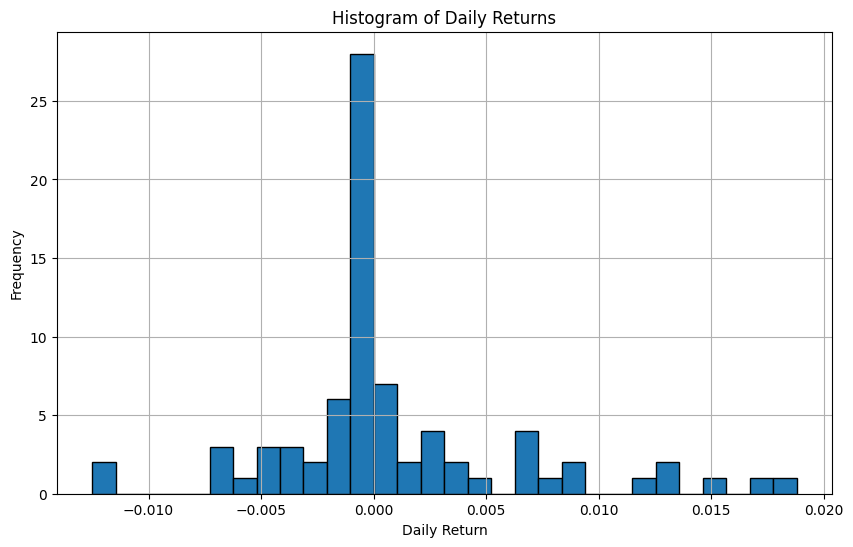

In [32]:
# Compute daily returns
daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

# Plot and save histogram of daily returns
plt.figure(figsize=(10, 6))
plt.hist(daily_returns, bins=30, edgecolor='k')
plt.title("Histogram of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(os.path.join(plots_path, 'daily_returns_histogram.png'))
plt.show()

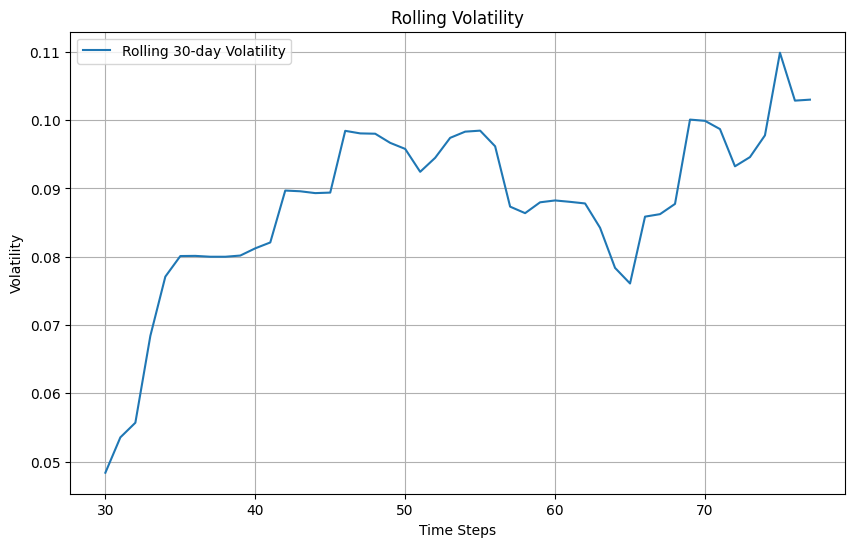

In [33]:

# Compute rolling volatility (e.g., 30-day volatility)
rolling_vol = portfolio_series.pct_change().rolling(window=30).std() * np.sqrt(252)

# Plot and save rolling volatility
plt.figure(figsize=(10, 6))
plt.plot(rolling_vol, label="Rolling 30-day Volatility")
plt.title("Rolling Volatility")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_path, 'rolling_volatility.png'))
plt.show()

In [ ]:
# Load stored price data
true_prices = np.load(os.path.join(evaluations_path, 'true_prices.npy'))
predicted_prices = np.load(os.path.join(evaluations_path, 'predicted_prices.npy'))

if not os.path.exists(os.path.join(evaluations_path, 'stock_metrics.csv')):
    os.mkdir(os.path.join(evaluations_path, 'stock_metrics'))

with open(os.path.join(evaluations_path, 'stock_metrics.csv'), 'w') as f:
    f.write("Stock,MAE,MSE,R²\n")
    for stock_idx in range(N_STOCKS):
        mae = mean_absolute_error(true_prices[:, stock_idx], predicted_prices[:, stock_idx])
        mse = mean_squared_error(true_prices[:, stock_idx], predicted_prices[:, stock_idx])
        r2 = r2_score(true_prices[:, stock_idx], predicted_prices[:, stock_idx])
        f.write(f"{stock_idx},{mae},{mse},{r2}\n")

# Calculate average metrics
mae_avg = np.mean([mean_absolute_error(true_prices[:, i], predicted_prices[:, i]) for i in range(N_STOCKS)])
mse_avg = np.mean([mean_squared_error(true_prices[:, i], predicted_prices[:, i]) for i in range(N_STOCKS)])
r2_avg = np.mean([r2_score(true_prices[:, i], predicted_prices[:, i]) for i in range(N_STOCKS)])

# Define x-axis for forecasting
x_future = np.arange(len(historical_prices), len(historical_prices) + len(predicted_prices))  # Forecast period

# Plot stock forecasting
plt.figure(figsize=(12, 6))
plt.plot(x_future, true_prices[:, stock_idx], label="True Future Prices", color='green', linewidth=2)
plt.plot(x_future, predicted_prices[:, stock_idx], label="Predicted Future Prices", color='red', linestyle="dashed", linewidth=2)
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title(f"Stock Forecasting for {stock_idx}")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_path, f'stock_forecasting_{stock_idx}.png'))
plt.show()